# TODO:
### DQN on cartpole 
- [x] Read about DQN and plan classes
- [ ] Test for dtypes, shapes, correct gradient changes, everything is a tensor, tests for making sure no_grad is on in the right points
- [ ] Assert optimiser has zero grad just before it calculates the gradients
- [ ] Make sure every input to a network is a tensor, and every input to a gym env is of right type and shape

#### Questions/cheat sheet
- When do i stop the gradients? Only have gradients when computing the loss for an update. 
    - Compute gradients for calculating things which have used the weights which need updating. 
    - I don't want requires_grad for environment outputs, only weights/params in the learnable nets
- Do the dimensions of inputs to network have to include batch size, even if it is always 1?  I think so. Whenever an input goes into a network basically.
- How do i pass a gradient through a distribution
    - Using rdist
- Convert everything that needs to go into a network to a tensor, float, device, has to have 0th dim as batch size when input for a net
    - Dtype is float for everything since tensors are only used to go in the network. 
    - So the dtype only matters in the networks, and float is safe for passing through networks.
- Use `.gather()` for getting the Q values as it is differentiable 
- Do i need to do a deepcopy of all transitions when sampling from buffer? 
    - No because I convert them to a tensor anyway which produces a new memory and reference
- Only need to transfer to device when I when I create a new tensor or model that you want the parameters to be on cuda. 
    - So model has params (weights) so it is on cuda, most loss functions are not on cuda, any inputs and outputs to something on cuda are on cuda, so states etc, inputs etc have to be on cuda.

In [2]:
import gym
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import deque
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
from copy import deepcopy
from typing import List, Tuple, Dict
from gym import Space
import random

In [3]:
ENVNAME = 'CartPole-v1'
env = gym.make(ENVNAME)
env2 = gym.make('BipedalWalker-v3')

C:\Users\akshil\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
def get_gym_space_shape(space):
    if isinstance(space, Box):
        return space.shape[0]
    elif isinstance(space, Discrete):
        return space.n
    else:
        raise TypeError("You haven't input a valid gym space. Here is your input: {}".format(space))

In [5]:
def numpy_to_torch_dtype(np_dtype):
    numpy_to_torch_dtype = {
        np.bool_       : torch.bool,
        np.uint8      : torch.uint8,
        np.int8       : torch.int8,
        np.int16      : torch.int16,
        np.int32      : torch.int32,
        np.int64      : torch.int64,
        np.float16    : torch.float16,
        np.float32    : torch.float32,
        np.float64    : torch.float64,
        np.complex64  : torch.complex64,
        np.complex128 : torch.complex128
    }
    return numpy_to_torch_dtype[np_dtype]

In [6]:
class Network(nn.Module):
    def __init__(self, design: List):
        super().__init__()
        self.layers = []

        # Define each layer according to arch.
        for i in range(len(design)):
            layer_type, params = design[i]
            self.layers.append(layer_type(**params))

        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        assert type(x) == torch.Tensor
        assert x.dim() > 1
        assert x.dtype in [float, torch.float, torch.float64]
        out = self.net(x)
        return out

In [7]:
class Memory:
    """
    Memeory does not convert what is given from the environment. It only provides storage and access.
    """
    def __init__(self, max_len, device):
        self.max_len = max_len
        self.buffer = self._reset_buffer()
        self.device = device
#         self.state_dtype = numpy_to_torch_dtype(env.observation_space.dtype)
#         self.action_dtype = numpy_to_torch_dtype(env.action_space.dtype)
    
    
    def __len__(self):
        return len(self.buffer)
    
    def _reset_buffer(self):
        return deque(maxlen=self.max_len)
    
    def sample(self, num_samples):
        """
        returns an iterable(states, actions, rewards, dones, next_states)
        """
        buffer_len = len(self.buffer)
        # If there aren't enough samples then take the min
        samples = random.sample(self.buffer, min([num_samples, buffer_len]))
        
        # separate lists for each part of transition
        states, actions, rewards, dones, next_states = zip(*samples)
        
        # Convert to tensors and put on device
        # calculate targets with target net 
        states = torch.tensor(states, dtype=torch.float, device=self.device) # shape:(mb_size, state_dim) using torch.float downgrades to float32 which i don't think matters...
        next_states = torch.tensor(next_states, dtype=torch.float, device=self.device) #shape: (mb_size, state_dim)
        actions = torch.tensor(actions, dtype=torch.float, device=self.device) # shape:(mb_size, action_dim) used for indexing only 
        
        rewards = torch.tensor([rewards], dtype=torch.float, device=self.device) # mb_size,added to output
        dones = torch.tensor(dones, dtype=torch.int, device=self.device) # (mb_size, 1)
        
        return states, actions, rewards, dones, next_states
            
            
    def store(self, transition):
        self.buffer.append(transition)
        
    

In [8]:
def test_memory_sample():
    m = Memory(100, 'cuda' if torch.cuda.is_available() else 'cpu')
    ENVNAME = 'CartPole-v1'
    env = gym.make(ENVNAME)
    
    s = env.reset()
    for i in range(50):
        a = env.action_space.sample()
        s_, r, d, _ = env.step(a)
        t = [s, a, r, d, s_]
        m.store(t)
        if d: 
            s = env.reset()
        
    states, actions, rewards, dones, next_states = m.sample(120)
    assert len(m) == 50
    assert states.shape == (50, 4)
test_memory_sample()

## Main

In [9]:
ENVNAME = 'CartPole-v1'
env = gym.make(ENVNAME)
m = Memory(100, 'cuda')
s = env.reset()
for i in range(50):
    a = env.action_space.sample()
    s_, r, d, _ = env.step(a)
    t = [s, a, r, d, s_]
    m.store(t)
    if d: 
        s = env.reset()

states, actions, rewards, dones, next_states = m.sample(120)

In [10]:
input_dim = get_gym_space_shape(env.observation_space)
output_dim = get_gym_space_shape(env.action_space)
net_layers = [(nn.Linear, {"in_features": input_dim, "out_features": 16}), 
              (nn.ReLU, {}),
              (nn.Linear, {"in_features": 16, "out_features": 4}),
              (nn.ReLU, {}),
              (nn.Linear, {"in_features": 4, "out_features": output_dim})]
cartpole_env = gym.make('CartPole-v1')

In [11]:

dqn_args = {'gamma'          : 0.9,
            'epsilon'        : 0.3,
            'eps_decay_rate' : 0.999,
            'env'            : cartpole_env,
            'step_lim'       : 200,
            'mb_size'        : 32,
            'net_design'     : net_layers,
            'optimiser'      : optim.Adam,
            'lr'             : 0.0001,
            'polyak_w'       : 1.,
            'memory_max_len' : 50000,
            'device'         : 'cpu', #torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
            'criterion'      : nn.MSELoss(),
            'target_update_freq' : 30            
           }

In [12]:
class DQN:
    def __init__(self, kwargs):
        # algo params
        self.gamma = kwargs['gamma']
        self.lr = kwargs['lr']
        self.epsilon = kwargs['epsilon']
        self.eps_decay_rate = kwargs['eps_decay_rate']
        self.mb_size = kwargs['mb_size']
        self.polyak_w = kwargs['polyak_w']
        
        # env params
        self.step_lim = kwargs['step_lim']
        self.env = kwargs['env']
        
        self.device = kwargs['device']
        self.memory = Memory(kwargs['memory_max_len'], self.device)
        self.q = Network(kwargs['net_design']) # use for action selection (nograd) and learning(grad)
        self.q.to(self.device)
        self.target_q = deepcopy(self.q)
        self.target_q.eval()
        self.target_update_freq = kwargs['target_update_freq']
        self._target_timer = 0
        self.criterion = kwargs['criterion']
        self.optimiser = kwargs['optimiser'](self.q.parameters(), self.lr)

    @torch.no_grad()
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([state], dtype=torch.float, device=self.device) # now passing through network, so should be float really
            
            self.q.eval()
            # convert to numpy so you can do random choice of max vals
            q_vals = self.q(state).cpu().detach().numpy() # (1, num_ac) do i need to detach given that i have already no_grad?
            self.q.train()
    
            greedy_actions = np.where(q_vals == q_vals.max())[0] 
            action = np.random.choice(greedy_actions)
        
        assert self.env.action_space.contains(action)
        return action
                 
    def _q_update(self):
        states, actions, rewards, dones, next_states = self.memory.sample(self.mb_size)
        rewards = rewards.squeeze(0)
        
        # Online Q net - track this for backprop
        state_q_vals = self.q(states)
        
        # actions are converted to ints and used as indices, then the whole thing is squeezed to match targets shape for loss
        q_preds = torch.gather(state_q_vals, -1, actions.long().unsqueeze(-1))
        q_preds.squeeze_(-1)
        
        assert q_preds.shape == (self.mb_size,)
    
        # Target Q net
        with torch.no_grad():
            nxt_tgt_net_vals = self.target_q(next_states) # shape:(m_batch, n_actions)
            assert nxt_tgt_net_vals.shape == (self.mb_size, 2)
            
            # Get the max over columns and take only the values - not indices
            max_tgt_net_vals = torch.max(nxt_tgt_net_vals, dim=1)[0] # shape: (m_batch, 1)
#             max_tgt_net_vals.unsqueeze_(-1)
            
            assert max_tgt_net_vals.shape == (self.mb_size,), max_tgt_net_vals.shape # does this shape work for subtraction/addition?
            assert max_tgt_net_vals.shape == rewards.shape, rewards.shape
            assert max_tgt_net_vals.shape == dones.shape, dones.shape
            
            q_targets = rewards + self.gamma * (1 - dones) * max_tgt_net_vals # check
            
            assert q_preds.shape == q_targets.shape
            print(q_preds.shape)
        
        # learn
        self.optimiser.zero_grad()
        loss = self.criterion(q_preds, q_targets) # maybe unsqueeze inputs here?
        loss.backward()
        self.optimiser.step()
        
        return True
        
    # Tested
    def _eps_decay(self):
        if self.eps_decay_rate != 1:
            self.epsilon *= self.eps_decay_rate
        return True
    
    
    # TODO: Test this works and there are no grads?
    @torch.no_grad()
    def _target_update(self):
        self.target_q.load_state_dict(self.q.state_dict())
        return True
    
    # TODO: Check this is complete and test it
    def update(self):
        """ 
        Wrapper function around the component updates
        """
        self._eps_decay()
        
        self._target_timer += 1
        if self._target_timer % self.target_update_freq == 0:
            self._target_update()
        
        # If the agent has collected enough experience
        if len(self.memory) > self.mb_size:
            self._q_update()
        
        return True
    
    # TODO: Comment this and test
    def run_episode(self, render=False):
        state = self.env.reset()
        total_reward = 0
        i = 0
        
        while i < self.step_lim:
            action = self.choose_action(state)
            next_state, reward, done, _= self.env.step(action)
            total_reward += reward
            
            if render: self.env.render()
            
            self.memory.store((state, action, reward, done, next_state))
            self.update()
                
            if done: break
            state = next_state
            i += 1
        return total_reward
    
    def train(self, num_epi, render=False):
        rewards = [self.run_episode(render) for _ in range(num_epi)]
        return rewards
    

In [13]:
agent = DQN(dqn_args)

In [16]:
torch.randn(3, 5, requires_grad=True).shape

torch.Size([3, 5])

### Testing Network

In [ ]:
import gym
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import deque
from gym.spaces.box import Box
from typing import List, Tuple
from deeprl.common.utils import get_gym_space_shape, net_gym_space_dims
from torch.distributions import Categorical
from deeprl.common.base import *
from deeprl.common.utils import *

In [ ]:
ENVNAME = 'MountainCar-v0'
env = gym.make(ENVNAME)
env2 = gym.make('BipedalWalker-v3')

In [ ]:
env.action_space.n

3

In [ ]:
des = [
    (nn.Linear, {"in_features":net_gym_space_dims(env.observation_space), "out_features":128}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features":128, "out_features": 64}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features":64, "out_features": net_gym_space_dims(env.action_space)})
]

In [ ]:
Network(des)

Network(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

### Testing Policy

In [ ]:
state = env.reset()
state = torch.from_numpy(state).unsqueeze(0)
policy = CategoricalPolicy(des)
a = policy.get_action(state)
lp = policy.get_log_prob(state, a)
ent = policy.get_entropy(state)

assert env.action_space.contains(a.cpu().detach().squeeze().numpy())
assert type(lp) == torch.Tensor
assert lp.dtype == torch.float
assert lp.requires_grad
assert lp.shape == (1,)

assert type(ent) == torch.Tensor
assert ent.dtype == torch.float
assert ent.requires_grad
assert ent.shape == (1,)


ValueError: The value argument to log_prob must be a Tensor

In [ ]:
state = env.reset()
states = torch.stack([torch.from_numpy(state.astype(np.float32)).to('cpu') for _ in range(10)])
policy = CategoricalPolicy(des)
a = policy.get_action(states)
lp = policy.get_log_prob(states, a)
ent = policy.get_entropy(states)


In [ ]:
print(a.shape, lp.shape, ent.shape)

torch.Size([10]) torch.Size([10]) torch.Size([10])


In [ ]:
env = gym.make("CartPole-v1")
policy_layers = [
    (nn.Linear,
        {"in_features": net_gym_space_dims(env.observation_space),
        "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 20,
        "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear,{"in_features": 20, "out_features": net_gym_space_dims(env.action_space)}),
]

critic_layers = [
    (nn.Linear, {"in_features": net_gym_space_dims(env.observation_space), "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear,
        {"in_features": 20,
        "out_features": 20}),
    (nn.ReLU, {}),
    (nn.Linear, {"in_features": 20, "out_features": 1}),
]

a2c_args = {
    "gamma": 0.99,
    "env": env,
    "step_lim": 200,
    "policy": CategoricalPolicy(policy_layers),
    "policy_optimiser": optim.Adam,
    "policy_lr": 0.002,
    "critic": Network(critic_layers),
    "critic_lr": 0.002,
    "critic_optimiser": optim.Adam,
    "critic_criterion": nn.MSELoss(),
    "device": "cpu",
    "entropy_coef": 0.01,
    "batch_size": 256,
    "num_train_passes": 1,
    "lam": 0.95,
    "num_eval_episodes": 15
}


NameError: name 'gym' is not defined

### Testing choose action

In [ ]:
agent = A2C(a2c_args)
s = env.reset()
for _ in range(200):
    a = agent.choose_action(s)
    assert env.action_space.contains(a)
    assert lp.requires_grad
    assert ent.requires_grad
    s_, r, d, _ = env.step(a)
    if d:
        s = env.reset()
    else:
        s = s_

NameError: name 'A2C' is not defined

In [ ]:
agent=A2C(a2c_args)

In [ ]:
agent.choose_action(agent.env)

TypeError: must be real number, not TimeLimit

In [ ]:
p_b = process_batch(out[1][1], 'cpu')

In [ ]:
compute_td_deltas(batch=p_b, gamma=0.99, critic=agent.critic)

tensor([[0.9812],
        [1.0230],
        [0.9809],
        [1.0228],
        [1.0191],
        [1.0182],
        [1.0113],
        [0.9876],
        [1.0115],
        [1.0076],
        [0.9990],
        [0.9986],
        [1.0782],
        [0.8529],
        [1.0221],
        [0.9806],
        [0.9873],
        [0.9725],
        [1.0309],
        [1.0163],
        [1.0209],
        [0.9812],
        [0.9834],
        [1.0193],
        [1.0187],
        [0.9832],
        [0.9791],
        [1.0234],
        [0.9744],
        [0.9574],
        [0.9554],
        [1.2706],
        [0.8938],
        [1.0224],
        [0.9787],
        [1.0213],
        [0.9796],
        [1.0207],
        [0.9801],
        [0.9847],
        [0.9891],
        [0.9829],
        [1.0215],
        [0.9835],
        [0.9874],
        [1.0175],
        [0.9871],
        [0.9780],
        [0.9640],
        [0.9618],
        [1.0427],
        [0.9605],
        [0.9610],
        [0.9630],
        [0.9606],
        [1

In [ ]:
plt.figure(figsize=(20,12))
plt.title('A2C-GAE on CartPole')
plt.xlabel('Epoch')
plt.ylabel('Episodic Reward')
plt.plot(out[-1])
# plt.legend()

plt.savefig('./data/a2c_gae_cartpole_learning_curve.PNG')
plt.show()



In [ ]:
num_agents = 5
num_epi = 200
r = []

for i in range(num_agents):
    print("Running training for agent number {}".format(i))
    agent = A2C(a2c_args)
        
    # random.seed(i)
    # np.random.seed(i)
    # torch.manual_seed(i)
    # env.seed(i)

    r.append(agent.train(num_epi))

out = np.array(r).mean(0)

plt.figure(figsize=(5, 3))
plt.title('A2C on cartpole')
plt.xlabel('Episode')
plt.ylabel('Episodic Reward')
plt.plot(out, label='rewards')
plt.legend()

# plt.savefig('./data/a2c_cartpole.PNG')
plt.show()

Running training for agent number 0


AttributeError: 'A2C' object has no attribute 'train'

## Testing mutability of batches

In [ ]:
env = gym.vector.make("CartPole-v1", 2, asynchronous=False)

In [ ]:
env.reset()
a = [None for i in range(10)]
b = [None for i in range(10)]
c = []
state = deepcopy(envs.observations)
for i in range(10):
    
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    if done.all(): 
        print("hi")

    if i == 9:
        print(state, action, reward, next_state, done)

    a[i] = to_torch(state, 'cpu')
    b[i] = to_torch(next_state, 'cpu')
    c.append(to_torch(action, 'cpu'))

    state = next_state

[[-0.05743215 -0.5994613   0.09216133  1.0078765 ]
 [ 0.14062183  0.973484   -0.14432696 -1.535625  ]] [1 1] [1. 1.] [[-0.06942137 -0.40568253  0.11231886  0.7454989 ]
 [ 0.16009152  1.1700188  -0.17503946 -1.8696471 ]] [False False]


In [ ]:
for i in range(10):
    print((a[i]==b[i]).all())

tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [ ]:
for i in range(len(batches)):
    for j in range(len(batches[i]["states"])):
        if (batches[i]['states'][j]==batches[i]["next_states"][j]).all():
            print(i, j)
        

## Rollouts

In [ ]:
batch_idc = np.arange(len(batch["states"]))

In [ ]:
done_idc = batch_idc[1+(batch["dones"]==1.)]

In [ ]:
pos = batch["states"][done_idc][:, 0]
vel = batch["states"][done_idc][:, 1]

In [ ]:
bad_idc_pos = []
for i,p in enumerate(pos):
    if not (p >= -0.6 and p <= -0.4):
         bad_idc_pos.append((i, p))

bad_idc_vel = []
for j, v in enumerate(vel):
    if v != 0:

        bad_idc_vel.append(v)

In [ ]:
bad_idc_pos
np.mean(bad_idc_vel)

172.24993885357466

In [ ]:
tmp = rollout[0]
tmp[0][0]

tensor([-0.5505,  0.0000])

In [ ]:
np.array([np.random.uniform(low=-0.6, high=-0.4), 0]).dtype

dtype('float64')

In [ ]:
tmp[1][0]

tensor([-0.5493,  0.0012])

In [ ]:
tmp = rollout[1]
tmp[0][0]

tensor(2.)

In [ ]:
tmp[1][0]

tensor([-0.0142,  1.4199, -0.7142,  0.1855,  0.0146,  0.1258,  0.0000,  0.0000])

In [ ]:
num_epochs = 30
for e in range(num_epochs):
    rollout = collect_rollout(agent, envs)
    batch = process_rollout(agent, rollout)
    p_loss, c_loss = update_from_batch(agent, batch)
    eval_r = np.mean(agent.run_eval())
    print(eval_r)
    r += [eval_r]

-173.19239503584075
-172.60251215317984
-178.4782370483543
-228.68811073600472
-246.84225198321047
-207.11016635853153
-205.44626132737216
-207.95082643312372
-201.9979350696185
-172.19229196084765
-262.0337850983584
-237.85800533438777
-244.02309146455246
-220.46089739264394
-259.1555643045256
-206.80026404794995
-197.90201883677557
-200.51229603439552
-223.56058137078335
-235.4760735838833
-159.09357970284955
-222.77981919057373
-247.60019583526
-162.9159315495674
-208.20999207544304
-216.18628703965487
-170.72826976549806
-121.02861376572392
-162.5490992979451
-195.1374250578408


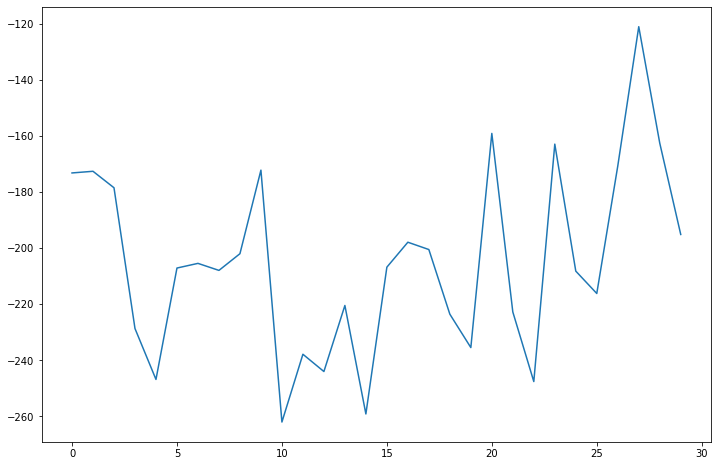

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r)
